_Alex Malz (NYU)_, _Javier Sanchez (UCI)_, & Others

_(Add your name here when contributing.)_

# Hack 'de Blend

This notebook outlines an approach to studying the systematics of Erin Sheldon's MOF pipeline due to blending as a function of (1) nearest neighbor distance and (2) nearest neighbor flux/magnitude.

In [16]:
import timeit

import astropy as ap
from astropy.io import fits
from astropy.table import Table

import pandas as pd

import fitsio
import numpy as np
import glob
import os

import _pickle as cpkl

from sklearn.neighbors import KDTree

from scipy.stats import binned_statistic
from scipy.stats import binned_statistic_2d

import matplotlib.pyplot as plt
%matplotlib inline

## Data

The data lives [on NERSC](/global/projecta/projectdirs/lsst/groups/WL/users/esheldon/nbrsim-outputs/collated/) and includes the following information in 5 150 GB `FITS` tables:

__HDU 0__:

SIMPLE  =                    T / file does conform to FITS standard

BITPIX  =                   16 / number of bits per data pixel

NAXIS   =                    0 / number of data axes

EXTEND  =                    T / FITS dataset may contain extensions

COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy

COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H

__HDU 1__:

XTENSION= 'BINTABLE'           / binary table extension

BITPIX  =                    8 / 8-bit bytes

NAXIS   =                    2 / 2-dimensional binary table

NAXIS1  =                 3040 / width of table in bytes

NAXIS2  =             52433036 / number of rows in table

PCOUNT  =                    0 / size of special data area

GCOUNT  =                    1 / one data group (required keyword)

TFIELDS =                   80 / number of fields in each row

TTYPE1  = 'id      '           / label for field   1

<TFORM1  = 'K       '           / data format of field: 8-byte INTEGER>

TTYPE2  = 'number  '           / label for field   2

<TFORM2  = 'J       '           / data format of field: 4-byte INTEGER>

TTYPE3  = 'ra      '           / label for field   3

<TFORM3  = 'D       '           / data format of field: 8-byte DOUBLE>

TTYPE4  = 'dec     '           / label for field   4

<TFORM4  = 'D       '           / data format of field: 8-byte DOUBLE>

TTYPE5  = 'nimage_tot'         / label for field   5

<TFORM5  = 'J       '           / data format of field: 4-byte INTEGER>

TTYPE6  = 'fofid   '           / label for field   6

<TFORM6  = 'K       '           / data format of field: 8-byte INTEGER>

TTYPE7  = 'flags   '           / label for field   7

<TFORM7  = 'J       '           / data format of field: 4-byte INTEGER>

TTYPE8  = 'time_last_fit'      / label for field   8

<TFORM8  = 'D       '           / data format of field: 8-byte DOUBLE>

TTYPE9  = 'box_size'           / label for field   9

<TFORM9  = 'I       '           / data format of field: 2-byte INTEGER>

TTYPE10 = 'obj_flags'          / label for field  10

<TFORM10 = 'J       '           / data format of field: 4-byte INTEGER>

TTYPE11 = 'psf_flags'          / label for field  11

<TFORM11 = 'J       '           / data format of field: 4-byte INTEGER>

TTYPE12 = 'psf_flux'           / label for field  12

<TFORM12 = 'D       '           / data format of field: 8-byte DOUBLE>

TTYPE13 = 'psf_flux_err'       / label for field  13

<TFORM13 = 'D       '           / data format of field: 8-byte DOUBLE>

TTYPE14 = 'psf_flux_s2n'       / label for field  14

<TFORM14 = 'D       '           / data format of field: 8-byte DOUBLE>

TTYPE15 = 'nimage_use'         / label for field  15

<TFORM15 = 'J       '           / data format of field: 4-byte INTEGER>

TTYPE16 = 'mask_frac'          / label for field  16

<TFORM16 = 'D       '           / data format of field: 8-byte DOUBLE>

TTYPE17 = 'psfrec_T'           / label for field  17

<TFORM17 = 'D       '           / data format of field: 8-byte DOUBLE>

TTYPE18 = 'psfrec_g'           / label for field  18

<TFORM18 = '2D      '           / data format of field: 8-byte DOUBLE>

TTYPE19 = 'gauss_flags'        / label for field  19

<TFORM19 = 'J       '           / data format of field: 4-byte INTEGER>

TTYPE20 = 'gauss_pars'         / label for field  20

<TFORM20 = '6D      '           / data format of field: 8-byte DOUBLE>

TTYPE21 = 'gauss_pars_cov'     / label for field  21

<TFORM21 = '36D     '           / data format of field: 8-byte DOUBLE>

TTYPE22 = 'gauss_g '           / label for field  22

<TFORM22 = '2D      '           / data format of field: 8-byte DOUBLE>

TTYPE23 = 'gauss_g_cov'        / label for field  23

<TFORM23 = '4D      '           / data format of field: 8-byte DOUBLE>

TTYPE24 = 'gauss_max_flags'    / label for field  24

<TFORM24 = 'J       '           / data format of field: 4-byte INTEGER>

TTYPE25 = 'gauss_max_pars'     / label for field  25

<TFORM25 = '6D      '           / data format of field: 8-byte DOUBLE>

TTYPE26 = 'gauss_max_pars_cov' / label for field  26

<TFORM26 = '36D     '           / data format of field: 8-byte DOUBLE>

TTYPE27 = 'gauss_s2n_w'        / label for field  27

<TFORM27 = 'D       '           / data format of field: 8-byte DOUBLE>

TTYPE28 = 'gauss_chi2per'      / label for field  28

<TFORM28 = 'D       '           / data format of field: 8-byte DOUBLE>

TTYPE29 = 'gauss_dof'          / label for field  29

<TFORM29 = 'D       '           / data format of field: 8-byte DOUBLE>

TTYPE30 = 'gauss_flags_r'      / label for field  30

<TFORM30 = 'J       '           / data format of field: 4-byte INTEGER>

TTYPE31 = 'gauss_s2n_r'        / label for field  31

<TFORM31 = 'D       '           / data format of field: 8-byte DOUBLE>

TTYPE32 = 'gauss_T_r'          / label for field  32

<TFORM32 = 'D       '           / data format of field: 8-byte DOUBLE>

TTYPE33 = 'gauss_psf_T_r'      / label for field  33

<TFORM33 = 'D       '           / data format of field: 8-byte DOUBLE>

TTYPE34 = 'mcal_flags'         / label for field  34

<TFORM34 = 'K       '           / data format of field: 8-byte INTEGER>

TTYPE35 = 'mcal_g  '           / label for field  35

<TFORM35 = '2D      '           / data format of field: 8-byte DOUBLE>

TTYPE36 = 'mcal_g_cov'         / label for field  36

<TFORM36 = '4D      '           / data format of field: 8-byte DOUBLE>

TTYPE37 = 'mcal_pars'          / label for field  37

<TFORM37 = '6D      '           / data format of field: 8-byte DOUBLE>

TTYPE38 = 'mcal_pars_cov'      / label for field  38

<TFORM38 = '36D     '           / data format of field: 8-byte DOUBLE>

TTYPE39 = 'mcal_gpsf'          / label for field  39

<TFORM39 = '2D      '           / data format of field: 8-byte DOUBLE>

TTYPE40 = 'mcal_Tpsf'          / label for field  40

<TFORM40 = 'D       '           / data format of field: 8-byte DOUBLE>

TTYPE41 = 'mcal_T  '           / label for field  41

<TFORM41 = 'D       '           / data format of field: 8-byte DOUBLE>

TTYPE42 = 'mcal_T_err'         / label for field  42

<TFORM42 = 'D       '           / data format of field: 8-byte DOUBLE>

TTYPE43 = 'mcal_T_r'           / label for field  43

<TFORM43 = 'D       '           / data format of field: 8-byte DOUBLE>

TTYPE44 = 'mcal_s2n_r'         / label for field  44

<TFORM44 = 'D       '           / data format of field: 8-byte DOUBLE>

TTYPE45 = 'mcal_g_1p'          / label for field  45

<TFORM45 = '2D      '           / data format of field: 8-byte DOUBLE>

TTYPE46 = 'mcal_g_cov_1p'      / label for field  46

<TFORM46 = '4D      '           / data format of field: 8-byte DOUBLE>

TTYPE47 = 'mcal_pars_1p'       / label for field  47

<TFORM47 = '6D      '           / data format of field: 8-byte DOUBLE>

TTYPE48 = 'mcal_pars_cov_1p'   / label for field  48

<TFORM48 = '36D     '           / data format of field: 8-byte DOUBLE>

TTYPE49 = 'mcal_T_1p'          / label for field  49

<TFORM49 = 'D       '           / data format of field: 8-byte DOUBLE>

TTYPE50 = 'mcal_T_err_1p'      / label for field  50

<TFORM50 = 'D       '           / data format of field: 8-byte DOUBLE>

TTYPE51 = 'mcal_T_r_1p'        / label for field  51

<TFORM51 = 'D       '           / data format of field: 8-byte DOUBLE>

TTYPE52 = 'mcal_s2n_r_1p'      / label for field  52

<TFORM52 = 'D       '           / data format of field: 8-byte DOUBLE>

TTYPE53 = 'mcal_g_1m'          / label for field  53

<TFORM53 = '2D      '           / data format of field: 8-byte DOUBLE>

TTYPE54 = 'mcal_g_cov_1m'      / label for field  54

<TFORM54 = '4D      '           / data format of field: 8-byte DOUBLE>

TTYPE55 = 'mcal_pars_1m'       / label for field  55

<TFORM55 = '6D      '           / data format of field: 8-byte DOUBLE>

TTYPE56 = 'mcal_pars_cov_1m'   / label for field  56

<TFORM56 = '36D     '           / data format of field: 8-byte DOUBLE>

TTYPE57 = 'mcal_T_1m'          / label for field  57

<TFORM57 = 'D       '           / data format of field: 8-byte DOUBLE>

TTYPE58 = 'mcal_T_err_1m'      / label for field  58

<TFORM58 = 'D       '           / data format of field: 8-byte DOUBLE>

TTYPE59 = 'mcal_T_r_1m'        / label for field  59

<TFORM59 = 'D       '           / data format of field: 8-byte DOUBLE>

TTYPE60 = 'mcal_s2n_r_1m'      / label for field  60

<TFORM60 = 'D       '           / data format of field: 8-byte DOUBLE>

TTYPE61 = 'mcal_g_2p'          / label for field  61

<TFORM61 = '2D      '           / data format of field: 8-byte DOUBLE>

TTYPE62 = 'mcal_g_cov_2p'      / label for field  62

<TFORM62 = '4D      '           / data format of field: 8-byte DOUBLE>

TTYPE63 = 'mcal_pars_2p'       / label for field  63

<TFORM63 = '6D      '           / data format of field: 8-byte DOUBLE>

TTYPE64 = 'mcal_pars_cov_2p'   / label for field  64

<TFORM64 = '36D     '           / data format of field: 8-byte DOUBLE>

TTYPE65 = 'mcal_T_2p'          / label for field  65

<TFORM65 = 'D       '           / data format of field: 8-byte DOUBLE>

TTYPE66 = 'mcal_T_err_2p'      / label for field  66

<TFORM66 = 'D       '           / data format of field: 8-byte DOUBLE>

TTYPE67 = 'mcal_T_r_2p'        / label for field  67

<TFORM67 = 'D       '           / data format of field: 8-byte DOUBLE>

TTYPE68 = 'mcal_s2n_r_2p'      / label for field  68

<TFORM68 = 'D       '           / data format of field: 8-byte DOUBLE>

TTYPE69 = 'mcal_g_2m'          / label for field  69

<TFORM69 = '2D      '           / data format of field: 8-byte DOUBLE>

TTYPE70 = 'mcal_g_cov_2m'      / label for field  70

<TFORM70 = '4D      '           / data format of field: 8-byte DOUBLE>

TTYPE71 = 'mcal_pars_2m'       / label for field  71

<TFORM71 = '6D      '           / data format of field: 8-byte DOUBLE>

TTYPE72 = 'mcal_pars_cov_2m'   / label for field  72

<TFORM72 = '36D     '           / data format of field: 8-byte DOUBLE>

TTYPE73 = 'mcal_T_2m'          / label for field  73

<TFORM73 = 'D       '           / data format of field: 8-byte DOUBLE>

TTYPE74 = 'mcal_T_err_2m'      / label for field  74

<TFORM74 = 'D       '           / data format of field: 8-byte DOUBLE>

TTYPE75 = 'mcal_T_r_2m'        / label for field  75

<TFORM75 = 'D       '           / data format of field: 8-byte DOUBLE>

TTYPE76 = 'mcal_s2n_r_2m'      / label for field  76

<TFORM76 = 'D       '           / data format of field: 8-byte DOUBLE>

TTYPE77 = 'sxflags '           / label for field  77

<TFORM77 = 'J       '           / data format of field: 4-byte INTEGER>

TTYPE78 = 'shear_true'         / label for field  78

<TFORM78 = '2D      '           / data format of field: 8-byte DOUBLE>

TTYPE79 = 'shear_index'        / label for field  79

<TFORM79 = 'I       '           / data format of field: 2-byte INTEGER>

TTYPE80 = 'file_id '           / label for field  80

<TFORM80 = 'J       '           / data format of field: 4-byte INTEGER>

In [3]:
data_dir = '/global/projecta/projectdirs/lsst/groups/WL/users/esheldon/nbrsim-outputs/collated/'
filename = glob.glob(os.path.join(data_dir,'*.fits'))

In [8]:
with fits.open(data_dir + 'run-003a-max001.fits') as hdulist:
    print(hdulist.info())
    ngals = len(hdulist[1].data)
    print(ngals)

Filename: /global/projecta/projectdirs/lsst/groups/WL/users/esheldon/nbrsim-outputs/collated/run-003a-max001.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1                1 BinTableHDU    181   52433036R x 80C   [K, J, D, D, J, K, J, D, I, J, J, D, D, D, J, D, D, 2D, J, 6D, 36D, 2D, 4D, J, 6D, 36D, D, D, D, J, D, D, D, K, 2D, 4D, 6D, 36D, 2D, D, D, D, D, D, 2D, 4D, 6D, 36D, D, D, D, D, 2D, 4D, 6D, 36D, D, D, D, D, 2D, 4D, 6D, 36D, D, D, D, D, 2D, 4D, 6D, 36D, D, D, D, D, J, 2D, I, J]   
None
52433036


In [65]:
# params = ['ra', 'dec', 'shear_true', 'mcal_g', 'mcal_s2n_r', 'psf_flux']
# data = {}
# for key in params:
#     data[key] = np.empty(0)

warning: slow!!!

In [14]:
# file_id = fitsio.read(str(filename[0]), columns='file_id')
# uids = np.unique(file_id)
# # data = np.empty_like(uids)
# for i in range(len(uids[:10])):
#     w, = np.where(file_id == uids[i])
#     for key in params:
#         data[key] = np.concatenate((data[key], fitsio.read(filename[0], rows=w, columns=key)), axis=-1)

In [24]:
# def compute_stats(distance,y,cut=[],bins=30,r=(0,30)):
#     bias1, bin_edges, _ = binned_statistic(distance[cut],y[cut],statistic='mean',bins=bins,range=r)
#     dbias1, bin_edges, _ = binned_statistic(distance[cut],y[cut],statistic='std',bins=bins,range=r)
#     counts1, bin_edges, _ = binned_statistic(distance[cut],y[cut],statistic='count',bins=bins,range=r)
#     bin_center = 0.5*(bin_edges[1:]+bin_edges[:-1])
#     return bias1, dbias1/np.sqrt(counts1), bin_center

def compute_stats(x,y,z,bins,cut=[]):
    b1, binx, biny, _ = binned_statistic_2d(x[cut],y[cut],z[cut],statistic='sum',bins=bins)
    c1, binx, biny, _ = binned_statistic_2d(x[cut],y[cut],z[cut],statistic='count',bins=bins)
    b2, binx, biny, _ = binned_statistic_2d(x[cut],y[cut],z[cut]**2,statistic='sum',bins=bins)
    bin_center = 0.5*(bin_edges[1:]+bin_edges[:-1])
return b1, c1, b2, bin_center

In [23]:
indie_params = ['ra', 'dec', 'mcal_s2n_r', 'mcal_g_1p', 'mcal_g_1m', 'mcal_g_2p', 'mcal_g_2m']#, 'psf_flux']
# indie_data = {}
# for p in indie_params:
#     indie_data[p] = np.empty(ngals)
meaned_2d_params = ['shear_true', 'mcal_g']
meaned_vecs = {}
for p in meaned_2d_params:
    meaned_vecs[p] = np.empty(2)
meaned_1d_params = ['mcal_g_1p', 'mcal_g_1m', 'mcal_g_2p', 'mcal_g_2m']
meaned_scalars = {}
for p in meaned_1d_params:
    meaned_scalars[p] = 0.

In [ ]:
filename = glob.glob(os.path.join(data_dir,'*.fits'))
start = timeit.default_timer()
file_ids = fitsio.read(str(filename[0]), columns='file_id')
# print('read file_ids in '+str(timeit.default_timer()-start))
uids = np.unique(file_ids)
# nids = len(uids)
nids = 10
# g1sum = 0.0
# n = 0
alltime = 0.
# chunkn = np.empty(nids)
# d_all, dd_all, bcd_all = np.empty(nids), np.empty(nids), np.empty(nids)
b1_all, c1_all, db1_all, bc1_all = np.empty(nids), np.empty(nids), np.empty(nids), np.empty(nids)
b2_all, c2_all, db2_all, bc2_all = np.empty(nids), np.empty(nids), np.empty(nids), np.empty(nids)
for i in range(nids):
    uid = uids[i]
    start = timeit.default_timer()
    chunktime = 0.
    w, = np.where(file_ids == uid)
    indie_data = {}
    for key in indie_params:
        indie_data[key] = fitsio.read(filename, rows=w, columns=key)
#         indie_data[key][n:n+len(w)] = fitsio.read(filename, rows=w, columns=key)
    X = np.array((indie_data['ra'] * np.pi / 180, np.sin(indie_data['dec'] * np.pi / 180))).transpose()
    tree = KDTree(X, metric='euclidean')
    
    distance, indices = tree.query(X, k=2, return_distance=True)
    distance = distance * 180 / np.pi * 3600
    distance = distance[:,1]
    indices = indices[:,1]
#     d_all[i], dd_all[i], bcd_all[i] = compute_stats(distance, shear_bias[:,0], sb_cut)
    
    R11 = (indie_data['mcal_g_1p'] - indie_data['mcal_g_1m']) / 0.02
    R22 = (indie_data['mcal_g_2p'] - indie_data['mcal_g_2m']) / 0.02
    shear1 = data['mcal_g'][:,0] / R11
    shear2 = data['mcal_g'][:,1] / R22
    shear_bias1 = indie_data['shear_true'][:,0] - shear1
    shear_bias2 = indie_data['shear_true'][:,1] - shear2
#     shear_bias = indie_data['shear_true'] - indie_data['mcal_g']
    cut = np.logical_and(np.fabs(shear_bias1)<1000, np.fabs(shear_bias2)<1000, indie_data['mcal_s2n_r']>0)
        # make some selections here
#         keep, = numpy.where(....)
    b1_all[i], c1_all[i], db1_all[i], bc1_all[i] = compute_stats(distance, indie_data['mcal_s2n_r'], shear_bias1, 
                                                                 cut=cut, bins=50)
    b2_all[i], c2_all[i], db2_all[i], bc2_all[i] = compute_stats(distance, indie_data['mcal_s2n_r'], shear_bias2, 
                                                                 cut=cut, bins=50)
#     chunksize = len(w[cut])
#     for key in meaned_1d_params:
#         meaned_scalars[key][i] = compute_stats(distance, indie_data['mcal_s2n_r']. 
#                                                fitsio.read(str(filename[0]), rows=w[cut], columns=key), 
#                                                cut=cut, bins=50)
#     for key in meaned_2d_params:
#         meaned_vecs[key] += np.sum(fitsio.read(str(filename[0]), rows=w[cut], columns=key), axis=0) / chunksize
                                      #data['mcal_g'][keep,0]
        # do other sums here
#         keytime = timeit.default_timer()-start
#         print('processed '+key+' for '+str(i)+': '+str(chunksize)+' in '+str(keytime))
#         chunktime += keytime
#     alltime += chunktime
#     chunksize = len(w)
#     chunkn[i] = chunksize
#     n += len(chunksize)

# print('processed '+str(meaned_2d_params)+' in '+str(alltime))
    
# for key in meaned_params:
#     meaned_data[key] /= np.sum(chunkn)
# g1mean = g1sum/n
# calculate other means here

In [60]:
# for key in params:
#     data[key] = np.hstack(np.array(data[key]))

In [43]:
# data_dir = '/global/projecta/projectdirs/lsst/groups/WL/users/esheldon/nbrsim-outputs/collated/'
# filename = glob.glob(os.path.join(data_dir,'*.fits'))
# file_id = fitsio.read(str(filename[0]), columns='file_id')
# uids = np.unique(file_id)
# print(uids)
# data = np.empty_like(uids)
# for i in range(len(uids)):
#     w, = np.where(file_id == uids[i])
#     print(type(fitsio.read(filename[0], rows=w)))
# # data = np.array(data)

# #will eventually loop over all filename elements

In [12]:
# print(filename[0])

/global/projecta/projectdirs/lsst/groups/WL/users/esheldon/nbrsim-outputs/collated/run-003b-max001.fits


In [15]:
# data['ra']

array([ 289.38328095,  289.35200274,  289.42632974, ...,  289.48788002,
        289.66098872,  289.52271482])

In [46]:
# np.save('/global/cscratch1/sd/jsanch87/run-003b-max001_data_arr_dict',data)
# cpkl.dump(data, open('/global/cscratch1/sd/jsanch87/run-003b-max001_data_arr_dict'))

For now in `$SCRATCH`, eventually we can move it to a project space

## Calculating nearest neighbor statistics


### Finding the nearest neighbor

We use a KDTree to get the nearest neighbors since this is way faster than using the brute-force approach

The declination axis is not actually flat so we use the sine to use a pure euclidean distance

In [47]:
X = np.array((data['ra']*np.pi/180,np.sin(data['dec']*np.pi/180))).transpose()
tree = KDTree(X,metric='euclidean')

AttributeError: 'numpy.ndarray' object has no attribute 'sin'

### Getting the distance to the nearest neighbor

We query just for the first two nearest neighbors (the first one is the object itself)

In [31]:
distance, indices = tree.query(X, k=2, return_distance=True)

We used distance in radians. Converting to arcseconds... (We might want to change this later and use `astropy.units`.

In [33]:
distance = distance*180/np.pi*3600

We don't care about the null match

In [37]:
distance = distance[:,1]
indices = indices[:,1]

### Getting other properties of the nearest neighbor

In [229]:
shear_bias = data['shear_true']-data['mcal_g']

In [230]:
from scipy.stats import binned_statistic
from scipy.stats import binned_statistic_2d

In [274]:
cut = np.logical_and(np.fabs(shear_bias[:,0])<1000,np.fabs(shear_bias[:,1])<1000)

In [232]:
def compute_stats(distance,y,cut=[],bins=30,r=(0,30)):
    bias1, bin_edges, _ = binned_statistic(distance[cut],y[cut],statistic='mean',bins=bins,range=r)
    dbias1, bin_edges, _ = binned_statistic(distance[cut],y[cut],statistic='std',bins=bins,range=r)
    counts1, bin_edges, _ = binned_statistic(distance[cut],y[cut],statistic='count',bins=bins,range=r)
    bin_center = 0.5*(bin_edges[1:]+bin_edges[:-1])
    return bias1, dbias1/np.sqrt(counts1), bin_center

In [233]:
b1, db1, bc = compute_stats(distance,shear_bias[:,0],cut)
b2, db2, bc = compute_stats(distance,shear_bias[:,1],cut)

/usr/common/software/python/3.6-anaconda-4.4/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


In [234]:
import matplotlib.pyplot as plt
%matplotlib inline

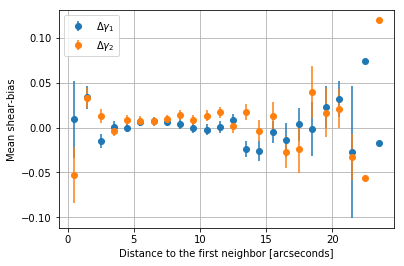

In [235]:
plt.errorbar(bc,b1,db1,marker='o',linestyle='none',label=r'$\Delta\gamma_{1}$')
plt.errorbar(bc,b2,db2,marker='o',linestyle='none',label=r'$\Delta\gamma_{2}$')
plt.xlabel('Distance to the first neighbor [arcseconds]')
plt.ylabel('Mean shear-bias')
plt.legend(loc='best')
plt.grid()

In [272]:
# multiplicative bias as function of NN distance in bins by SNR

def gen_plot(x, y, bin_by, num_bins):
    bins = np.linspace(np.min(bin_by), np.max(bin_by), num_bins+1)
    print(bins)
    for i in range(num_bins):
        inds = np.where(np.logical_and(bin_by > bins[i],bin_by < bins[i+1]))[0]
        b1, db1, bc = compute_stats(x,y,inds)
        plt.errorbar(bc,b1,db1,marker='o',linestyle='none')

In [276]:
print(np.min(data['mcal_s2n_r'][indices]),np.max(data['mcal_s2n_r'][indices]))

-9999.0 1637.43287399


We plot the mean bias for three different SNR bins

[    2.23412785   516.47335808  1030.71258831  1544.95181854]


/usr/common/software/python/3.6-anaconda-4.4/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


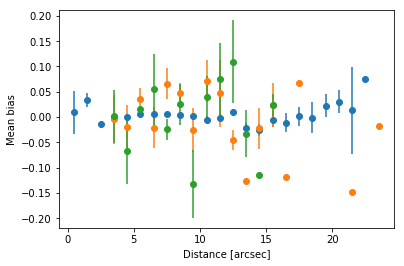

In [285]:
cut2 = np.logical_and(data['mcal_s2n_r'][indices]>0,cut)
gen_plot(distance[cut2], shear_bias[:,0][cut2], data['mcal_s2n_r'][indices][cut2], 3)
plt.xlabel('Distance [arcsec]')
plt.ylabel('Mean bias')

We plot the bias as a fuction of the distance for 3 different input shear

/usr/common/software/python/3.6-anaconda-4.4/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


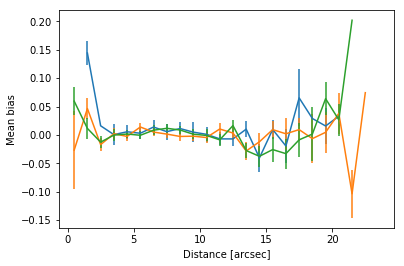

In [287]:
for st in np.unique(data['shear_true'][:,1]):
    cut3 = np.logical_and(cut,data['shear_true'][:,1]==st)
    b_0, db_0, bc = compute_stats(distance,shear_bias[:,0],cut3)
    plt.errorbar(bc,b_0,db_0,label='$\gamma_{2}=%.3f' %(st))
plt.xlabel('Distance [arcsec]')
plt.ylabel('Mean bias')

In [269]:
#3 bins in shear, after selecting in snr and distance
bin_over = [distance[cut] , data['mcal_s2n_r'][cut]]
distance_bins = np.arange(0,22,2)
snr_bins = np.arange(0,25,5)
unique_g = np.unique(data['shear_true'][:,1])
dg = unique_g[2]-unique_g[1]
mean_bias = np.zeros((len(np.unique(data['shear_true'][:,1])),len(distance_bins)-1,len(snr_bins)-1))
std_bias = np.zeros_like(mean_bias)
bins = [distance_bins,snr_bins]
for i,ishear in enumerate(np.unique(data['shear_true'][:,1])):
    new_cut = np.logical_and(cut,np.fabs(data['shear_true'][:,1]-ishear)<0.005)
    mean_bias[i,:,:], binx,biny, _ = binned_statistic_2d(distance[new_cut] , data['mcal_s2n_r'][indices][new_cut], shear_bias[:,0][new_cut], bins=bins)
    std_bias[i,:,:], binx,biny, _ = binned_statistic_2d(distance[new_cut] , data['mcal_s2n_r'][indices][new_cut], shear_bias[:,0][new_cut], statistic='std', bins=bins)
    mult_bias = (mean_bias[2,:,:]-mean_bias[1,:,:])/dg
    dmult_bias = 1./dg*np.sqrt(std_bias[2,:,:]**2+std_bias[1,:,:]**2)

In [270]:
mult_bias

array([[  6.64901523,  -4.0425671 ,   1.10609343, -11.92967865],
       [ -3.56519202,   0.90211572,  -1.05576239,  -6.09883224],
       [  0.10834472,  -1.42806756,  -0.9686831 ,   5.68482718],
       [ -1.82220979,   0.39482146,   3.73226226,   1.90017458],
       [  0.80693167,   0.44811734,   1.75370781,   1.61216942],
       [ -6.83102085,  -1.21748773,   5.61938446,   1.23646091],
       [  4.87353244,   0.06508378,  -2.02653247,  -3.06374349],
       [ -6.61672244,  -1.0658857 ,  -1.33710448,   6.38821404],
       [-13.15729644,   4.21003911, -11.40909453,  -9.7977893 ],
       [         nan,  -0.32932918,          nan,          nan]])

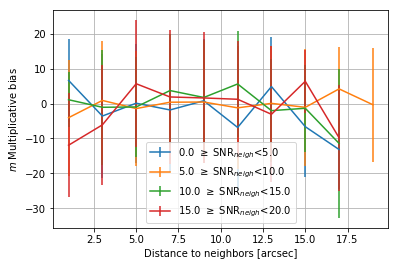

In [271]:
for i in range(len(snr_bins)-1):
    plt.errorbar(0.5*distance_bins[1:]+0.5*distance_bins[:-1],mult_bias[:,i],dmult_bias[:,i],label=r'%.1f $\geq$ SNR$_{neigh}$<%.1f' %(snr_bins[i],snr_bins[i+1]))
plt.xlabel('Distance to neighbors [arcsec]')
plt.legend(loc='best')
plt.ylabel('$m$ Multiplicative bias')
plt.grid()

## Transform any parameters as necessary

### Multiplicative shear bias

### Mean shear

## Plot all the things